In [2]:
import pandas as pd
import numpy as np
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('df5_2102.csv')

sensor_id = [329, 332, 335]
freezer_id = [344, 362, 368]

In [ ]:
import random
for col in ['operation_'+ str(_id) for _id in freezer_id]:
    df[col+'_random'] = [random.randint(0,1) for r in range(len(df))]

In [ ]:
cols = ['gw_time'] + ['temperature_329']+['humidity_329']+ ['temperature_329_prime'] + ['dT_329'] + ['operation_'+str(_id) for _id in freezer_id] +['operation_'+str(_id)+'_random' for _id in freezer_id]
df = df[cols]

In [ ]:
df = df.dropna()

In [ ]:
TEST_SIZE = 8000
train = df[:-TEST_SIZE]
test = df[-TEST_SIZE:]
train.shape, test.shape

((72120, 11), (8000, 11))

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
for col in cols[1:-3]:
    train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
    test[col] = scaler_test.fit_transform(test[col].values.reshape(-1,1))

C:\Users\Intellicode\AppData\Local\Temp\ipykernel_3636\2926434095.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[col] = scaler_train.fit_transform(train[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_3636\2926434095.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler_test.fit_transform(test[col].values.reshape(-1,1))
C:\Users\Intellicode\AppData\Local\Temp\ipykernel_3636\2926434095.py:6: SettingWithCopyWarning: 
A value is trying to be set on a cop

In [135]:
feature_cols1 = ['operation_'+str(_id) for _id in freezer_id] #+ ['temperature_329_prime'] + ['humidity_329']
feature_cols2 = ['operation_'+str(_id)+'_random' for _id in freezer_id] #+ ['temperature_329_prime']+ ['humidity_329']
label_cols =  ['dT_329']

In [1]:
df[label_cols]

NameError: name 'df' is not defined

In [136]:
train_feature = train[feature_cols1]
train_label = train[label_cols]

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2, shuffle = True)

x_train.shape, x_valid.shape
# ((57676, 20, 21), (14419, 20, 21))

((57696, 3), (14424, 3))

In [137]:
test_feature = test[feature_cols1]
test_feature2 = test[feature_cols2]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터)
test_feature.shape, test_label.shape

((8000, 3), (8000, 1))

In [144]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
# model.add(Dense(32,activation = 'ReLU'))
# model.add(Dense(64,activation = 'ReLU'))
model.add(Dense(32,activation='ReLU'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = './tmp_checkpoint.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=64,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint],
                    verbose = 1,
                    shuffle = True)

Epoch 1/200
900/902 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 1: val_loss improved from inf to 0.00298, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 4s 4ms/step - loss: 0.0074 - val_loss: 0.0030
Epoch 2/200
892/902 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 2: val_loss improved from 0.00298 to 0.00295, saving model to .\tmp_checkpoint.h5
902/902 [==============================] - 4s 4ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/200
900/902 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 3: val_loss did not improve from 0.00295
902/902 [==============================] - 4s 4ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 4/200
897/902 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 4: val_loss did not improve from 0.00295
902/902 [==============================] - 4s 4ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/200
899/902 [============================>.] - ETA: 0s - l

In [140]:
model.save('my_custom_model')

INFO:tensorflow:Assets written to: my_custom_model\assets


INFO:tensorflow:Assets written to: my_custom_model\assets


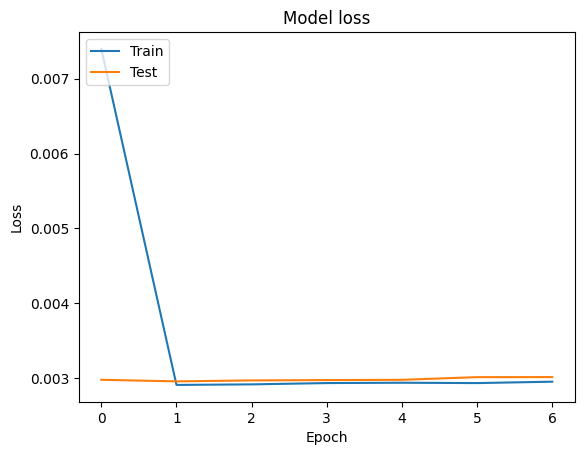

In [145]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [146]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)
pred2 = model.predict(test_feature2)

250/250 [==============================] - 1s 2ms/step


MSE:  0.012205833412480516
MAE:  0.09157702665031059


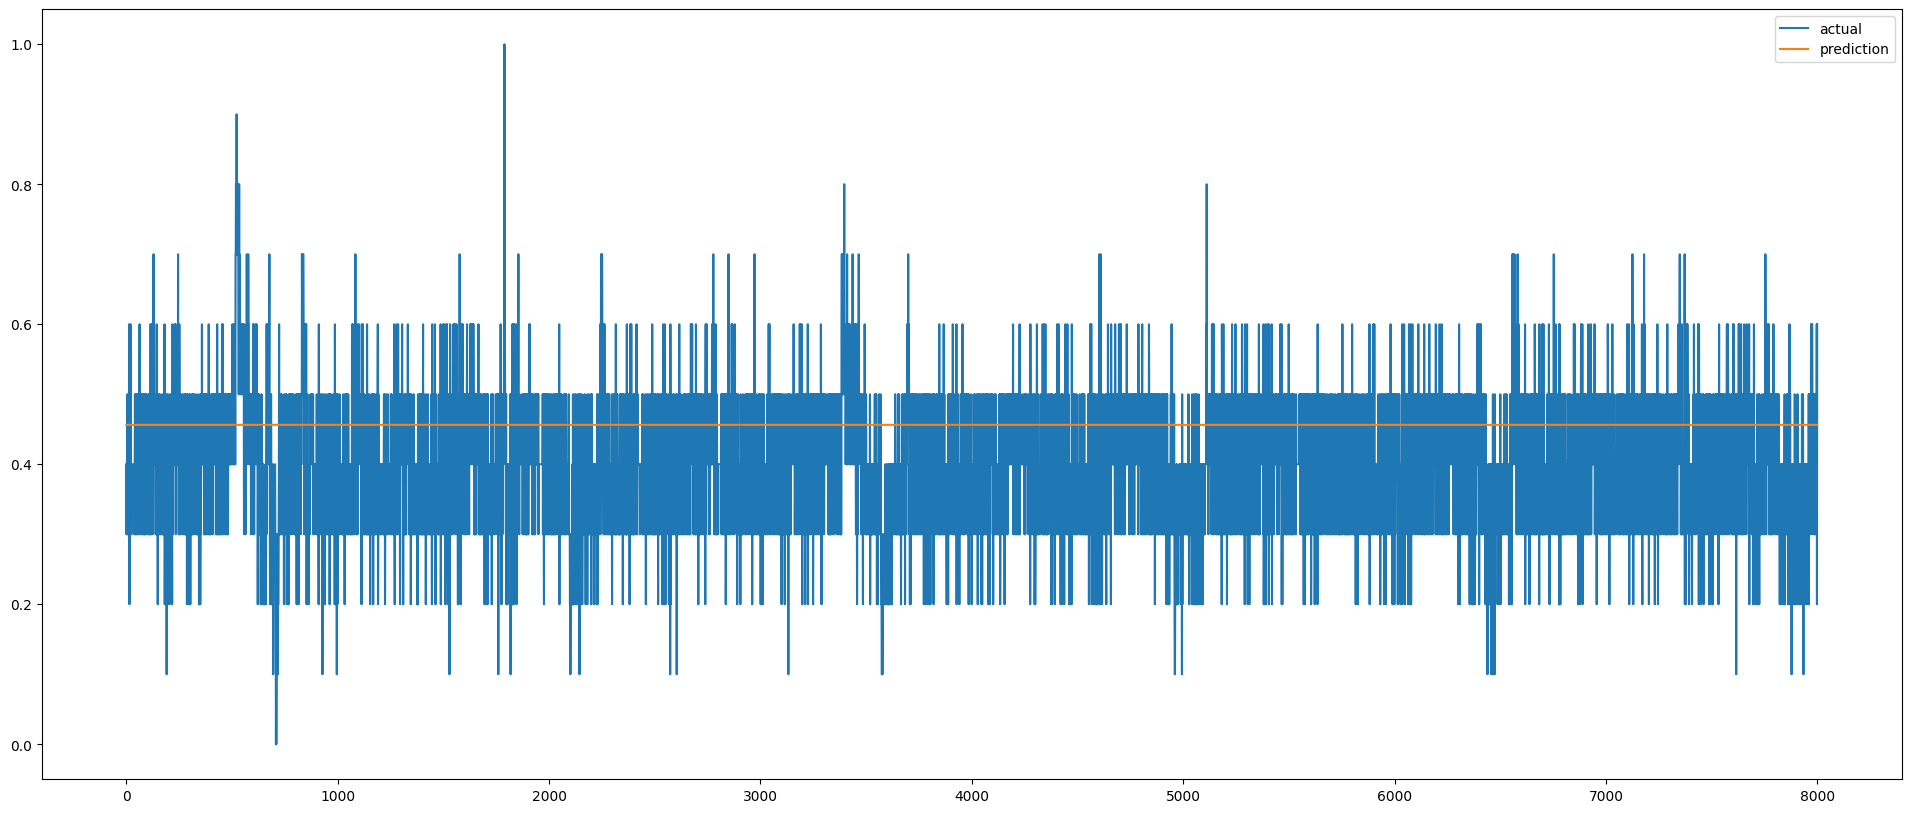

In [147]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(test_label.values, pred))
print("MAE: ", mean_absolute_error(test_label.values, pred))
plt.figure(figsize=(24,10))
plt.plot(test_label.values[:], label='actual')
plt.plot(pred[:], label='prediction')
plt.legend()
plt.show()

In [120]:
test_label.values[:20]

array([[0.30041152],
       [0.2962963 ],
       [0.2962963 ],
       [0.29218107],
       [0.29218107],
       [0.2962963 ],
       [0.2962963 ],
       [0.29218107],
       [0.29218107],
       [0.29218107],
       [0.29218107],
       [0.2962963 ],
       [0.29218107],
       [0.29218107],
       [0.30041152],
       [0.29218107],
       [0.29218107],
       [0.2962963 ],
       [0.29218107],
       [0.28806584]])

In [121]:
pred[:20]

array([[0.29850602],
       [0.29852733],
       [0.29455122],
       [0.29456452],
       [0.29062834],
       [0.29068956],
       [0.2947269 ],
       [0.29476416],
       [0.29080668],
       [0.29084134],
       [0.2908892 ],
       [0.29093447],
       [0.2949532 ],
       [0.2909877 ],
       [0.29098505],
       [0.2989373 ],
       [0.2909744 ],
       [0.2910223 ],
       [0.29504633],
       [0.29108623]], dtype=float32)

MSE:  0.010041209866676847
MAE:  0.07921227328851922


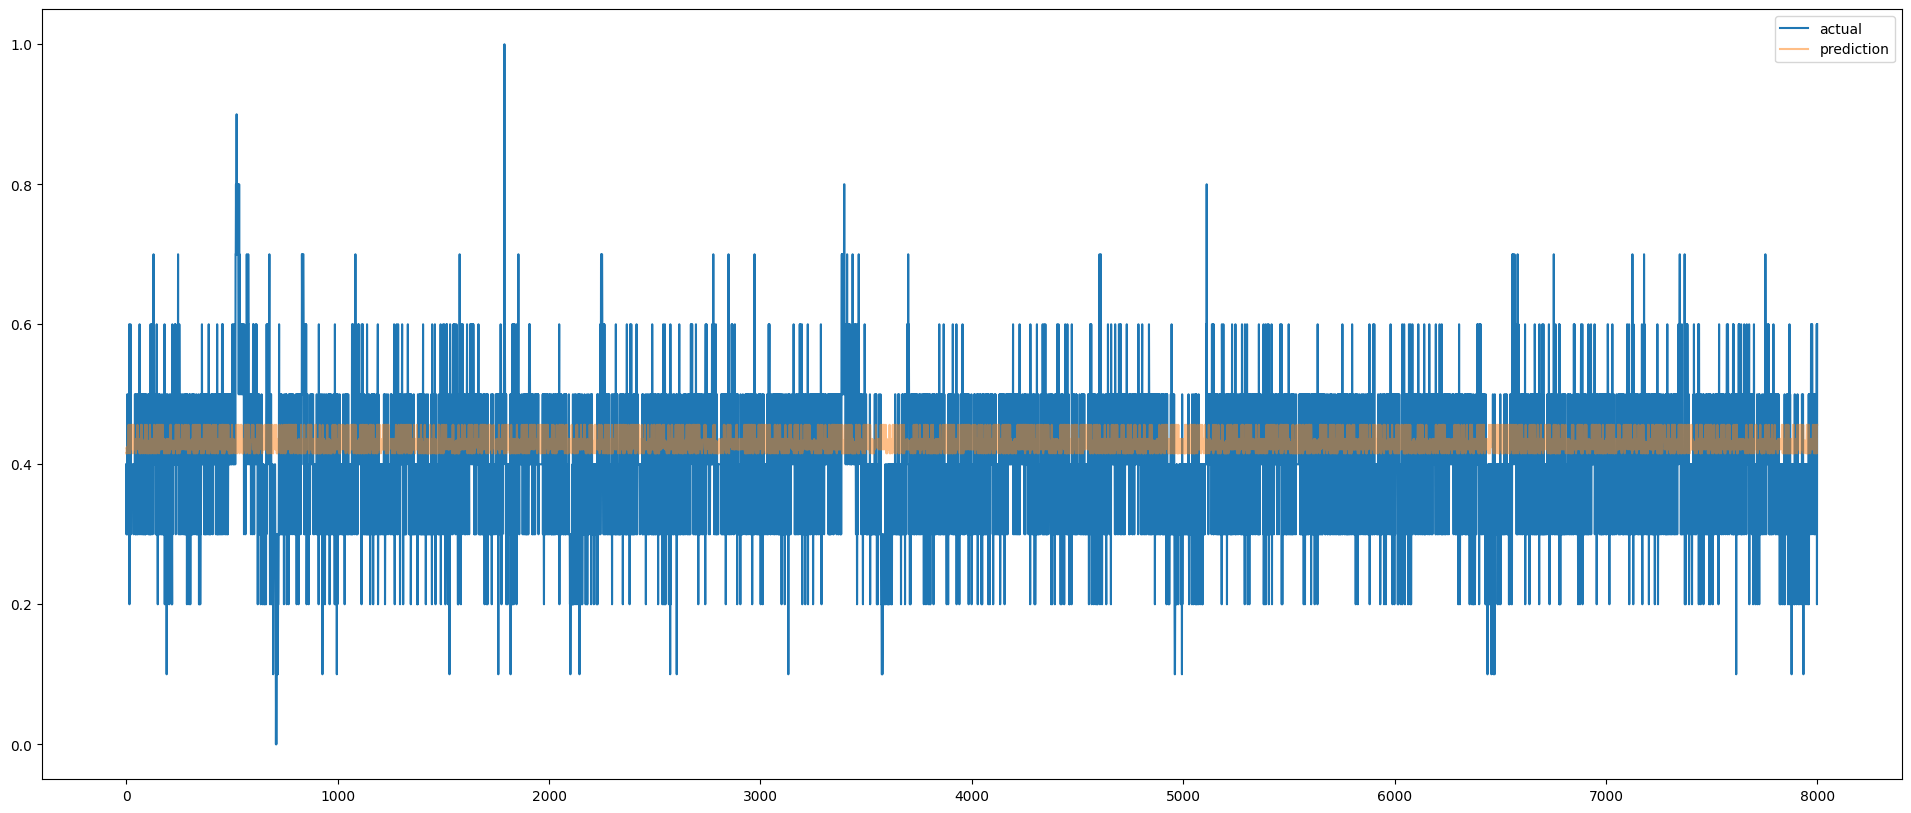

In [148]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

print("MSE: ", mean_squared_error(test_label.values, pred2))
print("MAE: ", mean_absolute_error(test_label.values, pred2))
plt.figure(figsize=(24,10))
plt.plot(test_label.values, label='actual')
plt.plot(pred2, label='prediction', alpha = 0.5)
plt.legend()
plt.show()